In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from datetime import date
from datetime import timedelta
from fpdf import FPDF
from IPython.display import HTML
import os
import numpy as np
from scipy.signal import savgol_filter
import glob

from dateutil import parser
import datetime
import dataframe_image as dfi

os.chdir('../best_deck_yesterday')
%load_ext autotime

time: 0 ns (started: 2022-06-14 12:36:04 -04:00)


In [2]:
names = []
csvs = glob.glob('../data/derived/previous-patches/*.csv')

#make a long df
for proj in csvs:
    frame = pd.read_csv(proj, usecols=['deck_code', 'game_outcome', 'archetype']).dropna()
    names.append(frame)
    james = pd.concat(names)

time: 10.9 s (started: 2022-06-14 12:36:04 -04:00)


In [3]:
one_more = pd.read_csv('../data/raw/lor_ranked_data_all.csv', usecols=['deck_code', 'game_outcome', 'archetype']).dropna()

time: 4.44 s (started: 2022-06-14 12:36:14 -04:00)


In [4]:
df_full = pd.concat([james, one_more])

time: 109 ms (started: 2022-06-14 12:36:19 -04:00)


In [5]:
df_date = df_full
df = df_full

time: 0 ns (started: 2022-06-14 12:36:19 -04:00)


In [6]:
n = 3

time: 0 ns (started: 2022-06-14 12:36:19 -04:00)


In [7]:
archetypes = df_date['deck_code'].value_counts()
archetypes = archetypes[archetypes > n]
popular_list = list(archetypes.index)
x = df.loc[df['deck_code'].isin(popular_list)]

time: 2.19 s (started: 2022-06-14 12:36:19 -04:00)


In [8]:
df_champ = x[x['game_outcome'] != "tie"] # get rid of ties
df_champ = df_champ.groupby(['deck_code', 'game_outcome']).size() # group deck codes by outcome
df_champ = df_champ.groupby(level=0).transform(lambda x: (x / x.sum()).round(3)*100) # get winrate
df_champ.drop('loss', level=1, axis=0, inplace=True) # drop losses
df_champ = df_champ.droplevel(level=1) # not sure
df_champ = df_champ.sort_values(ascending=False) # sort so good stuff at top
df_champ = pd.DataFrame({'deck_code':df_champ.index, 'winrate':df_champ.values}) #dataframe w/ column titles

time: 1min 26s (started: 2022-06-14 12:36:21 -04:00)


In [9]:
df_ = df_date[['deck_code', 'archetype']].copy() # make a dataframe with just the stuff you need
_ = pd.merge(df_champ, df_, on=['deck_code'], copy=False).drop_duplicates().reset_index(drop=True)#[:20] # get the archetypes for top decks, drop dupes, reset index, keep top 10

time: 4.03 s (started: 2022-06-14 12:37:48 -04:00)


In [10]:
z = df_date.value_counts('deck_code')
z = pd.DataFrame(z, columns = ['n_games'])
_ = _.merge(z, how='inner', on= 'deck_code')

time: 2.94 s (started: 2022-06-14 12:37:52 -04:00)


In [12]:
r = _
r_small = r[['winrate', 'n_games']]
r_small = r_small[r_small['n_games'] < 1000]

time: 31 ms (started: 2022-06-14 12:38:16 -04:00)


In [13]:
r_small['n_games'].max()

998

time: 0 ns (started: 2022-06-14 12:38:17 -04:00)


In [14]:
poop = r_small
poop['n_games'].max()

998

time: 0 ns (started: 2022-06-14 12:38:17 -04:00)


In [15]:
s_max = r_small.groupby(['n_games']).max()
s_mean = r_small.groupby(['n_games']).mean()
s_min = r_small.groupby(['n_games']).min()

time: 32 ms (started: 2022-06-14 12:38:18 -04:00)


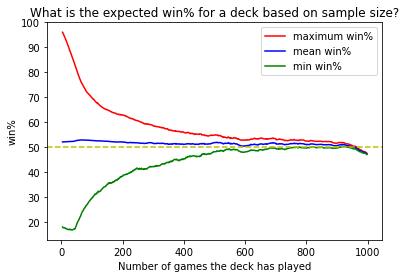

time: 312 ms (started: 2022-06-14 12:38:18 -04:00)


In [16]:
window_len = 75
poly_order = 1

x = s_max.index
yhat = savgol_filter(s_max['winrate'], window_len, poly_order, mode='nearest')

x_mean = s_mean.index
yhat_mean = savgol_filter(s_mean['winrate'], window_len, poly_order, mode='nearest')

x_min = s_min.index
yhat_min = savgol_filter(s_min['winrate'], window_len, poly_order, mode='nearest')

# plt.plot(x, y)
plt.plot(x,yhat, color='red', label="maximum win%")
plt.plot(x_mean, yhat_mean, color='blue', label="mean win%")
plt.plot(x_min, yhat_min, color='green', label="min win%")
plt.title('What is the expected win% for a deck based on sample size?')
plt.xlabel('Number of games the deck has played')
plt.ylabel('win%')
plt.axhline(y=50, color='y', linestyle='--')
plt.legend()
plt.show()
# plt.savefig('../game_length/winrateByLengthMultiplePatches.png', dpi=600)

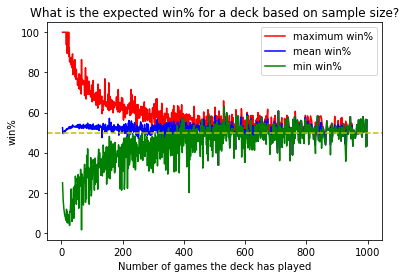

time: 172 ms (started: 2022-06-14 12:38:21 -04:00)


In [17]:
window_len = 75
poly_order = 1

x = s_max.index
# yhat = savgol_filter(s_max['winrate'], window_len, poly_order, mode='nearest')
yhat = s_max['winrate']

x_mean = s_mean.index
# yhat_mean = savgol_filter(s_mean['winrate'], window_len, poly_order, mode='nearest')
yhat_mean = s_mean['winrate']

x_min = s_min.index
# yhat_min = savgol_filter(s_min['winrate'], window_len, poly_order, mode='nearest')
yhat_min = s_min['winrate']

# plt.plot(x, y)
plt.plot(x,yhat, color='red', label="maximum win%")
plt.plot(x_mean, yhat_mean, color='blue', label="mean win%")
plt.plot(x_min, yhat_min, color='green', label="min win%")
plt.title('What is the expected win% for a deck based on sample size?')
plt.xlabel('Number of games the deck has played')
plt.ylabel('win%')
plt.axhline(y=50, color='y', linestyle='--')
plt.legend()
plt.show()
# plt.savefig('../game_length/winrateByLengthFullPatchUnsmooth.png', dpi=600)

In [20]:
lmao = _.sort_values(by='n_games', ascending=False)

time: 31 ms (started: 2022-06-14 12:38:31 -04:00)


In [21]:
lmao.to_csv('lmao.csv')

time: 937 ms (started: 2022-06-14 12:38:32 -04:00)


In [23]:
len(lmao)

212953

time: 0 ns (started: 2022-06-14 12:38:43 -04:00)


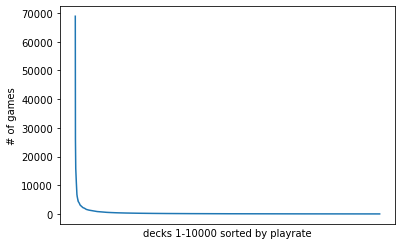

time: 17.3 s (started: 2022-06-14 12:43:39 -04:00)


In [29]:
plt.plot(lmao['deck_code'][:10000],lmao['n_games'][:10000])
plt.xlabel('decks 1-10000 sorted by playrate')
plt.ylabel('# of games')
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.savefig('longtail.png', dpi=300, facecolor='w')